In [4]:
import os
csv_dir = './diffs'
csv_list = os.listdir(csv_dir)
csvs = np.zeros((64, 0))
for f in csv_list:
    data = np.genfromtxt(os.path.join(csv_dir, f), delimiter=',', skip_header=False) # np.loadtxt(os.path.join(csv_dir, f))
    # print(data.shape)
    csvs = np.concatenate((csvs, data), axis=1)
print(csvs.shape)
np.save('combined.dat', csvs)

(64, 891488)


TypeError: _save_dispatcher() got an unexpected keyword argument 'delimiter'

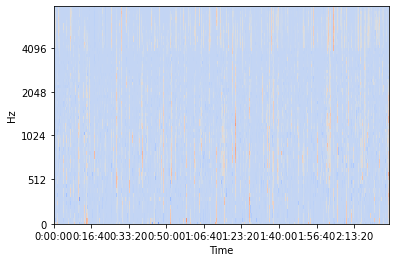

In [9]:
csvs.shape
import librosa.display
librosa.display.specshow(csvs, sr=16000, hop_length=160, x_axis='time', y_axis='mel')

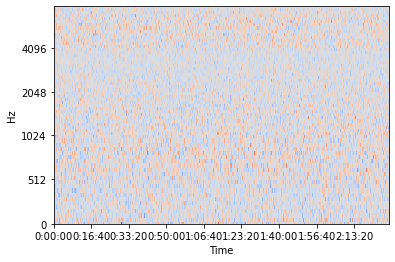

In [16]:
data = csvs
gen = np.empty(data.shape)
means = np.mean(data, axis=1)
stds = np.std(data, axis=1)
for i, (mean, std) in enumerate(zip(means, stds)):
    gen[i] = np.random.normal(mean, std, data.shape[1])
librosa.display.specshow(gen, sr=16000, hop_length=160, x_axis='time', y_axis='mel')

In [18]:
np.mean(data), np.min(data), np.max(data)


(0.050500508676152765, -1.2335540056228638, 1.7874153852462769)

In [21]:
import librosa
import os
import random
import soundfile as sf
import string
import librosa.display
import numpy as np

signal_dir_path = '/mnt/nvme2tb/datasets/voxceleb2/sorted/train'
ambient_dir = '/mnt/nvme2tb/datasets/ambient_noises'

signal_dirs = [f.path for f in os.scandir(signal_dir_path) if f.is_dir()]
#print(signal_dirs)

signal_index = []
for sigdir in signal_dirs:
    signal_index.extend([os.path.join(sigdir, el) for el in os.listdir(sigdir)])
#signal_index = os.listdir(signal_dir)
ambient_index = os.listdir(ambient_dir)

def A(raw_audio, sr=16000, n_mels=40, frame_length_ms=25, hop_ms=10):
    # 512 (32ms) vs 256 (16ms) when sr=16000 / optimal for speech is (512) 23ms with sr=22050
    # "frame length=25ms, frame shift=10ms" / 1/16000 => window = 400, hop = 160
    frame_length = int(frame_length_ms * sr / 1000)
    hop = int(hop_ms * sr / 1000)
    S = np.abs(
        librosa.stft(y=raw_audio,
                     n_fft=frame_length,
                     hop_length=hop,
                     window='hamming',
                     center=True))**2
    # Calculating mel_basis
    mel_basis = librosa.filters.mel(sr=sr,
                                    n_fft=frame_length,
                                    fmin=20,
                                    fmax=8000,
                                    htk=True,
                                    n_mels=n_mels)
    F = np.dot(mel_basis, S)
    return F


def Z(F):
    Fdb = librosa.power_to_db(F, ref=np.max)[:, :-1]
    return Fdb

def std(spg):
    return (spg + 40.) / 40.


# print(signal)  
#signal, sr = torchaudio.load(f1, normalize=True)
#transform = torchaudio.transforms.Resample(sr, 16000)
#print(signal.shape, sr)



'''
sf.write('signal.wav', signal, samplerate=sr)
sf.write('resampled.wav', signal, samplerate=sr)
#print(signal.shape, '16000')
ambient, sr = librosa.load(fa, mono=True)
librosa.resample(ambient, sr, 16000, fix=True)
ambient = ambient[:signal.shape[0]]
sf.write('ambient.wav', ambient, samplerate=sr)
'''

"\nsf.write('signal.wav', signal, samplerate=sr)\nsf.write('resampled.wav', signal, samplerate=sr)\n#print(signal.shape, '16000')\nambient, sr = librosa.load(fa, mono=True)\nlibrosa.resample(ambient, sr, 16000, fix=True)\nambient = ambient[:signal.shape[0]]\nsf.write('ambient.wav', ambient, samplerate=sr)\n"

/home/sergey/anaconda3/envs/torch/lib/python3.9/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


(111485,) 22050
(1002834,) 22050
0.15759264 0.034221556 0.18499069
0.02616808 0.0063482756 0.07967607
0.04841738 0.009935123 0.09967509
0.06903476 0.015106619 0.12290899
0.0828475 0.02031991 0.14254792
0.09258929 0.022547852 0.15015942
0.14060381 0.044185165 0.21020268
0.2055058 0.060476467 0.24591963
0.25754833 0.064956844 0.25486633
0.26341036 0.056951754 0.23864567
0.2384672 0.04961949 0.22275433
0.24052286 0.054633975 0.23373912
0.25325888 0.055656698 0.23591672
0.25507084 0.04894675 0.22123912
0.25928932 0.046497624 0.21563308
0.25133598 0.04397378 0.20969926
0.25314808 0.04869882 0.22067809
0.23967668 0.044667058 0.21134582
0.24477614 0.040737577 0.20183551
0.24683286 0.0478606 0.21877065
0.20621938 0.034566995 0.18592201
0.19523117 0.037296604 0.19312328
0.20644398 0.034751147 0.1864166
0.19313258 0.03353076 0.18311407
0.19228297 0.035340622 0.18799102
0.18236318 0.030934323 0.17588156
0.12868483 0.021659054 0.14717016
0.09432828 0.01768183 0.13297305
0.08560729 0.015097665 0.12

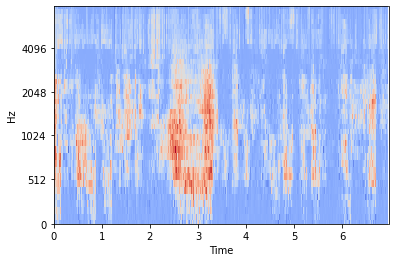

In [117]:
#import matplotlib.pyplot as plt

for j in range(100000):
    #print(j)
    signal, sr = librosa.load(random.choice(signal_index), mono=True)
    #print(signal.shape, sr)
    librosa.resample(signal, sr, 16000, fix=True)

    ambient, sr = librosa.load(os.path.join(ambient_dir, random.choice(ambient_index)), mono=True)
    #print(ambient.shape, sr)
    librosa.resample(ambient, sr, 16000, fix=True)
    start = random.randint(0, ambient.shape[0]-signal.shape[0])
    ambient_cut = ambient[start:start+signal.shape[0]]

    mixed = np.add(signal*.9, ambient_cut*.1)

    #sf.write('signal.wav', signal, samplerate=22050)
    #sf.write('ambient.wav', ambient_cut, samplerate=22050)
    #sf.write('mixed.wav', mixed, samplerate=22050)

    spgd = std(Z(A(signal)))
    spgs = std(Z(A(mixed)))
    spgdiff = spgs-spgd
    letters = string.ascii_lowercase
    fname = './diffs/' + ''.join(random.choice(letters) for i in range(10)) + '.csv'
    np.savetxt(fname, spgdiff, delimiter=",")
    #print(np.mean(spgdiff), np.var(spgdiff), np.std(spgdiff))
    #for i in range(spgdiff.shape[0]):
    #    print(np.mean(spgdiff[i]), np.var(spgdiff[i]), np.std(spgdiff[i]))
#librosa.display.specshow(spgdiff, sr=16000, hop_length=160, x_axis='time', y_axis='mel')

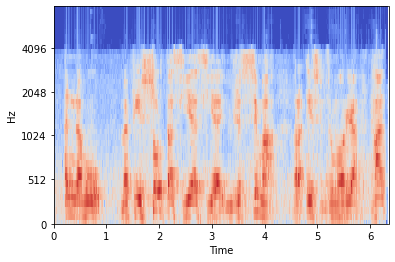

In [108]:
librosa.display.specshow(spgs, sr=16000, hop_length=160, x_axis='time', y_axis='mel')

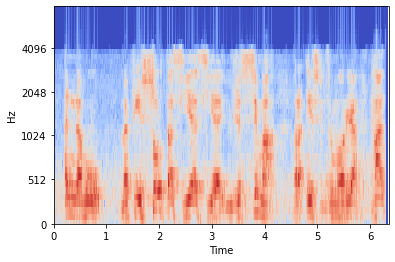

In [109]:
librosa.display.specshow(spgd, sr=16000, hop_length=160, x_axis='time', y_axis='mel')